# Análisis Exploratorio de Datos ( EDA )

En este Notebook, entenderemos los datos, describiremos y analizaremos para poder llegar a crear un set de datos óptimo para el algoritmo de recomendación. El algoritmo de recomendación para el cual se van a optimizar los datos serán:

```
def recomendacion_juego( id de producto ): Ingresando el id de producto, deberíamos recibir una lista con 5 juegos recomendados similares al ingresado.
```
En un futuro se implementará el algoritmo de usuario a item:

```
def recomendacion_usuario( id de usuario ): Ingresando el id de un usuario, deberíamos recibir una lista con 5 juegos recomendados para dicho usuario.
```

# 1. Importamos las librerías necesarias

In [74]:
import pandas as pd # Con pandas trabajaremos los datos.
import ast # Convertiremos una cadena de texto a una lista con ast.
import matplotlib.pyplot as plt # Con matplotlib graficaremos nuestros datos.
from sklearn.decomposition import PCA # Con PCA, haremos una reducción de dimensionalidad, ya que sabemos que hay demasiadas variables categóricas en nuestro dataframe de juegos, solo queremos las principales y que más nos aporten.
import seaborn as sns # Con seaborn, haremos gráficos de nuestros datos.

# 2. Cargamos y previsualizamos cada set de datos.
Por ahora solo necesitaremos el set de juegos, cuando se implemente el otro algoritmo, necesitaremos los demás.

In [75]:
df_game = pd.read_csv('../Data/Processed/games_recommend.csv')

In [76]:
df_game.head()

,publisher,genres,name,specs,price,early_access,id,developer,year
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,['Single-player'],4.99,0.00,761140,Kotoshiro,2018
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,"['Single-player', 'Multi-player', 'Online Mult...",0.00,0.00,643980,Secret Level SRL,2018
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,"['Single-player', 'Multi-player', 'Online Mult...",0.00,0.00,670290,Poolians.com,2017
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,['Single-player'],0.99,0.00,767400,彼岸领域,2017
4,Trickjump Games Ltd,"['Action', 'Adventure', 'Simulation']",Battle Royale Trainer,"['Single-player', 'Steam Achievements']",3.99,0.00,772540,Trickjump Games Ltd,2018


# 3. Seleccionamos las columnas objetivo de nuestro algoritmo.
Creamos el set de datos con el que trabajaremos con el algoritmo de recomendación.

In [77]:
df_games = df_game[['id', 'genres', 'specs', 'early_access', 'name']] # Recomendación de item en base a un item.
# En este caso extraemos el id, necesario para la búsqueda, junto con el nombre para el resultado, y las variables specs, genres y early_access, que serán las características del juego, con las que podremos compararlo con otros juegos.

Convertimos las columnas que tienen listas para poder iterar sobre ellas.

In [78]:
df_games['genres'] = df_games['genres'].apply(ast.literal_eval)
df_games['specs'] = df_games['specs'].apply(ast.literal_eval)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_17656\1831853252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['genres'] = df_games['genres'].apply(ast.literal_eval)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_17656\1831853252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['specs'] = df_games['specs'].apply(ast.literal_eval)


Creamos variables dummies de los géneros y las especificaciones.

In [79]:
genres_d = df_games['genres'].apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0) # Aplico una función que para cada elemento dentro de genres o specs, si está presente, le asigna un valor de 1 en una serie de pandas, y si no lo está, será 0.
specs_d = df_games['specs'].apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0)

Verificamos antes de agregarlas al dataframe.

In [80]:
display(genres_d.head())
specs_d.head()

,Action,Casual,Indie,Simulation,Strategy,Free to Play,RPG,Sports,Adventure,Racing,...,Remake,Time Attack,Anime,Side Scroller,Documentary,Controller,Memes,Detective,Mystery,Episodic
0,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,Single-player,Multi-player,Online Multi-Player,Cross-Platform Multiplayer,Steam Achievements,Steam Trading Cards,In-App Purchases,Stats,Downloadable Content,Full controller support,...,Mods,MMO,Online Co-op,Local Multi-Player,Includes Source SDK,Commentary available,Steam Turn Notifications,SteamVR Collectibles,Game demo,Mods (require HL2)
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Las agregamos al dataframe y eliminamos las columnas restantes.

In [81]:
df_games = pd.concat([df_games, genres_d, specs_d], axis=1)
df_games.drop(columns=['genres', 'specs'], inplace=True)

In [82]:
df_games.head()

,id,early_access,name,Action,Casual,Indie,Simulation,Strategy,Free to Play,RPG,...,Mods,MMO,Online Co-op,Local Multi-Player,Includes Source SDK,Commentary available,Steam Turn Notifications,SteamVR Collectibles,Game demo,Mods (require HL2)
0,761140,0.00,Lost Summoner Kitty,1.00,1.00,1.00,1.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,643980,0.00,Ironbound,0.00,0.00,1.00,0.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,670290,0.00,Real Pool 3D - Poolians,0.00,1.00,1.00,1.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,767400,0.00,弹炸人2222,1.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,772540,0.00,Battle Royale Trainer,1.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Verificamos que la columna early access no requiera una transformación.

In [83]:
df_games['early_access'].unique()

array([0., 1.])

Verificamos que los datos hayan quedado limpios.

In [84]:
df_games.isna().sum().sum()

0

# 4. Análisis de datos (DataFrame IA)
Empezamos a entender el dataframe resultante, para saber qué transformaciones le beneficiarán a nuestro algoritmo de recomendación. Para ver el análisis de los demás datos, sigue avanzando al punto 5.

## 4.1 Distribución

Observemos qué tan distribuidos están los géneros en nuestro dataframe.

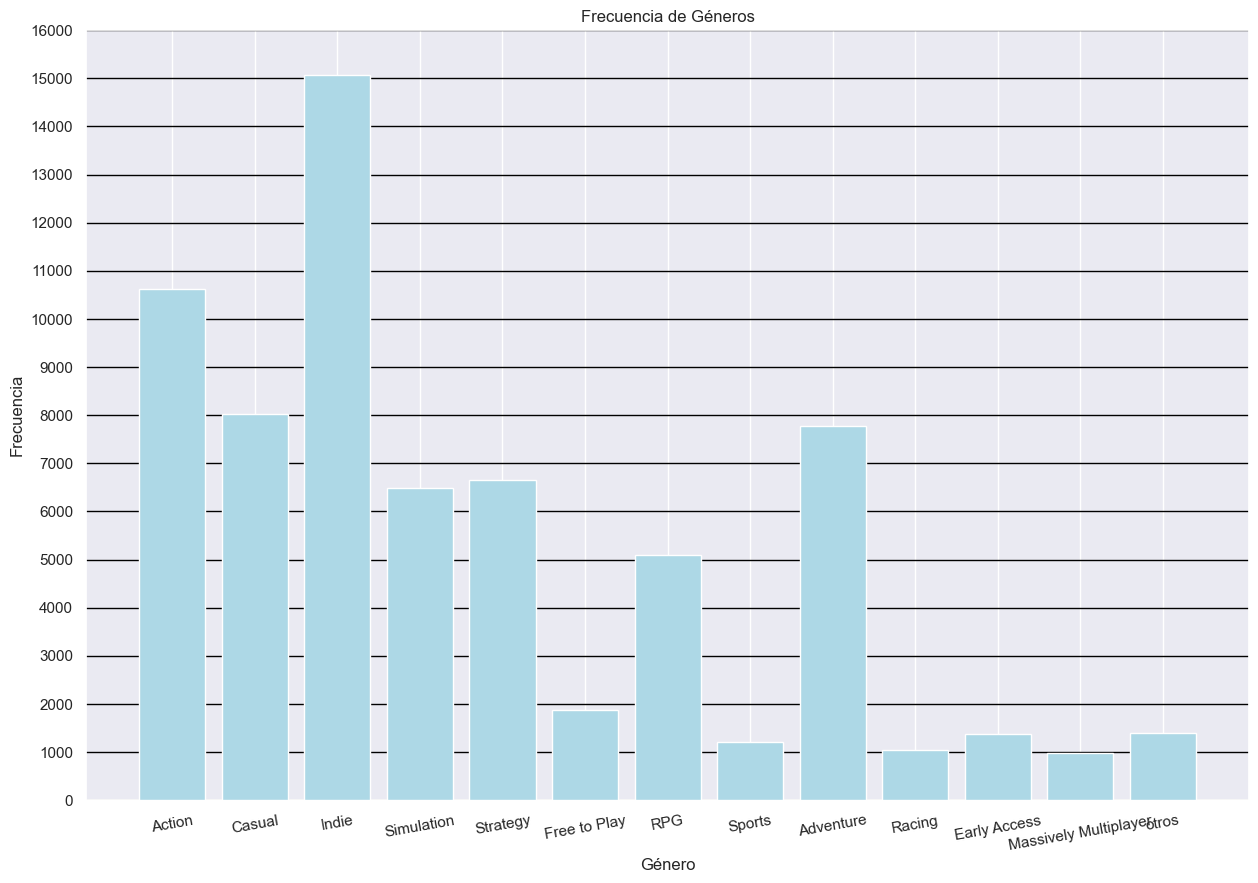

In [85]:
# Contamos las veces que aparece un género en los géneros.
conteo = genres_d.sum()
# Un umbral, ya que son muchas variables, las que no lo superen, serán de la categoría otros.
umbral = 500
# Contamos los juegos menor al umbral.
otros = conteo[conteo < umbral].sum()
# Contamos los que son mayores o iguales al umbral.
conteo = conteo[conteo >= umbral]
# Creamos la columna otros.
conteo['otros'] = otros
# Creamos la figura, con los datos obtenidos.
plt.figure(figsize=(15, 10)) 
plt.bar(conteo.index, conteo.values, color='lightblue', zorder=3)
plt.xlabel('Género')
plt.xticks(rotation=10)
plt.yticks(range(0, int(max(conteo.values)+1000), 1000))
plt.ylabel('Frecuencia')
plt.grid(axis='y', color='black', zorder=0)
plt.title('Frecuencia de Géneros')
plt.show()

Ahora las especificaciones.

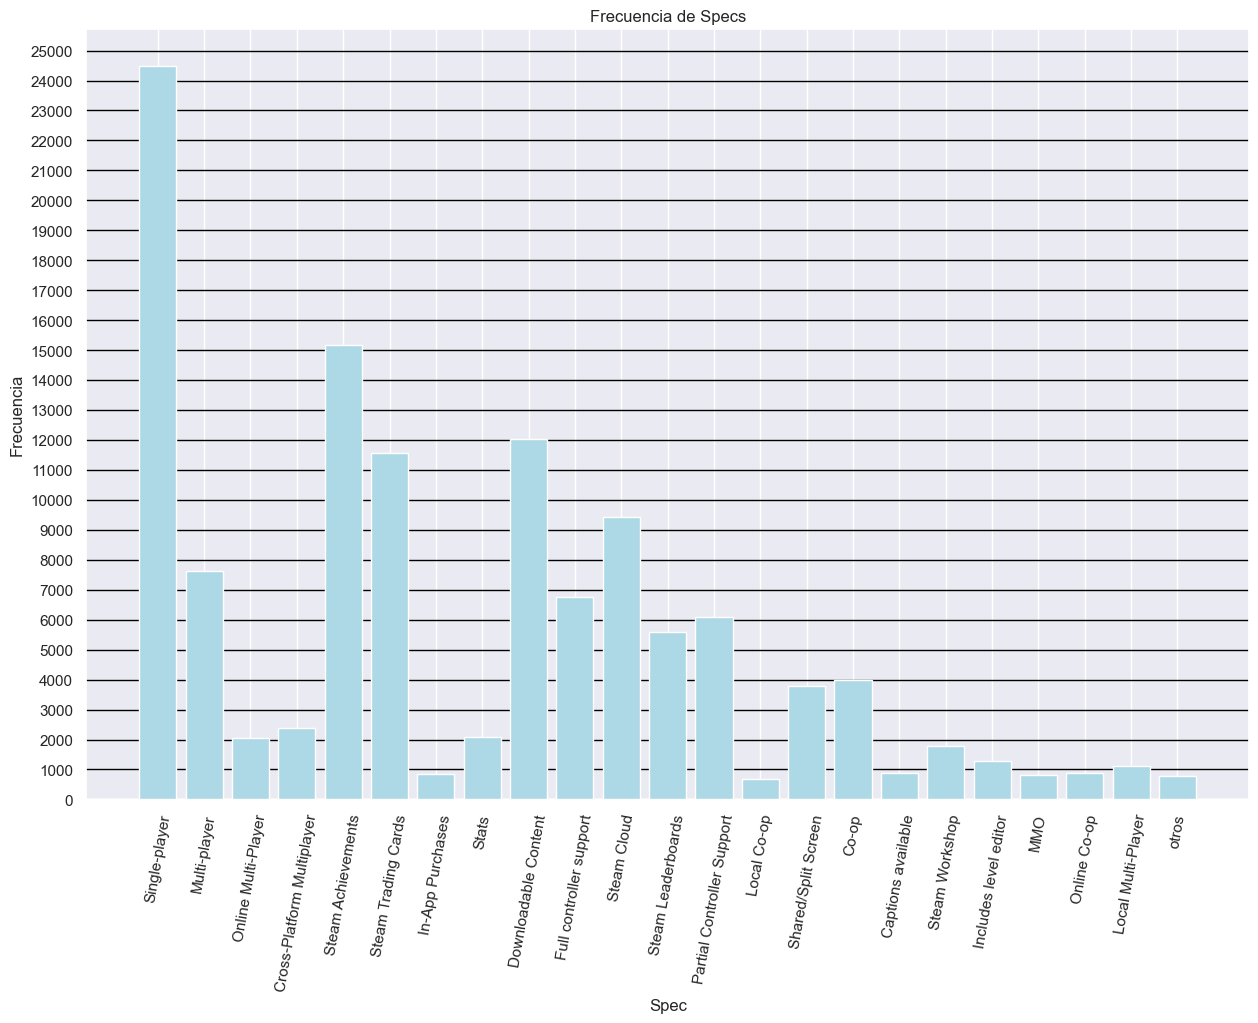

In [86]:
# Contamos las veces que aparece una spec entre todas.
conteo = specs_d.sum()
# Un umbral, ya que son muchas variables, las que no lo superen, serán de la categoría otros.
umbral = 500
# Contamos los juegos menor al umbral.
otros = conteo[conteo < umbral].sum()
# Contamos los que son mayores o iguales al umbral.
conteo = conteo[conteo >= umbral]
# Creamos la columna otros.
conteo['otros'] = otros
# Creamos la figura, con los datos obtenidos.
plt.figure(figsize=(15, 10)) 
plt.bar(conteo.index, conteo.values, color='lightblue', zorder=3)
plt.xlabel('Spec')
plt.xticks(rotation=80)
plt.yticks(range(0, int(max(conteo.values)+1000), 1000))
plt.ylabel('Frecuencia')
plt.grid(axis='y', color='black', zorder=0)
plt.title('Frecuencia de Specs')
plt.show()

## 4.2 Limpieza en base a la observación

En este caso, filtré las variables para que si llegaban a aparecer más de 500 veces, se mostraran como otros, en el caso de Géneros, podemos ver que hay varias variables que dominan en este umbral, como lo son indie, acción, casual, simulación, estrategia, aventura y RPG, mientras que en el caso de specs, la variable single player domina mucho más que las demás, luego, también llegan a verse varias variables que logran superar el umbral por bastante.

Analizando esto, decido realizar una limpieza a los datos, ya que tenemos una gran cantidad de variables que no llegarán a ser muy significativas para el modelo, para esto uso el identificador de componentes principales PCA de scikit learn, el cual nos ayudará a identificar cuantas variables principales queremos en nuestro dataframe, y a obtener un valor dentro de esas variables, que logre abarcar al dataframe de una manera más óptima, he decidido crear 10 componentes, después de efectuar unas visualizaciones manuales y de ver cómo se comportaba con distintos números. Además, el PCA no se limita a valores positivos, sino a negativos, por lo que filtrará mejor el dataframe si se planea saber cuales juegos son menos similares a otros. Entiendo que el PCA no es la manera más óptima de reducir un set de datos con variables categóricas, pero puede ayudar a reducir rápidamente la dimensionalidad que estamos teniendo en este set para lograr el Mvp(Producto viable mínimo), y se planteará usar una tecnología específica para categorización a futuro.

In [87]:
# Creo el analizador de componentes principales.
pca = PCA(n_components=10)
# Obtenemos una matriz de dichos componentes, excluyendo el id y el nombre, ya que estos no son características, son identificadores.
df_pca = pca.fit_transform(df_games.drop(columns=['id', 'name']))

In [88]:
# Creo un dataframe en base a la matriz, con las columnas de 1 a 10.
df_pca = pd.DataFrame(data=df_pca, columns=[str(n) for n in range(1, 11)])
# Agrego el id y el nombre correspondiente al dataframe de los componentes principales.
df_pca = pd.concat([df_games[['id', 'name']], df_pca], axis=1)

Observamos el dataframe resultante.

In [89]:
df_pca.head()

,id,name,1,2,3,4,5,6,7,8,9,10
0,761140,Lost Summoner Kitty,-0.66,-0.39,-0.40,0.31,0.77,-0.54,0.04,-0.06,-0.26,0.14
1,643980,Ironbound,-0.35,0.31,0.90,1.39,0.09,0.26,-0.68,0.65,0.04,-0.06
2,670290,Real Pool 3D - Poolians,-0.69,0.20,-0.37,0.44,1.04,-0.53,0.17,0.70,0.32,0.73
3,767400,弹炸人2222,-0.66,-0.77,-0.36,-0.73,0.13,0.07,0.24,0.28,0.73,-0.26
4,772540,Battle Royale Trainer,-0.11,-0.47,-0.25,-0.74,-0.23,0.07,-0.34,0.02,0.23,0.59


Con las variables convertidas, exportamos el set de datos para su uso en el cuaderno de Machine Learning, en el cual se usará la similitud del coseno para hallar los N productos similares necesarios.

In [90]:
df_pca.to_csv('games_ML.csv', index=False)

# 5. Análisis de datos (DataFrame Juegos)
Analizamos los datos de los juegos presentes en Steam.

Observamos que no haya quedado ningún nulo en el previo ETL.

In [91]:
df_game.isna().sum()

publisher       19
genres           0
name             0
specs            0
price            0
early_access     0
id               0
developer        0
year             0
dtype: int64

Borramos los nulos

In [92]:
df_game.dropna(inplace=True)

Previsualizamos nuevamente el dataframe

In [93]:
df_game.head(3)

,publisher,genres,name,specs,price,early_access,id,developer,year
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,['Single-player'],4.99,0.00,761140,Kotoshiro,2018
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,"['Single-player', 'Multi-player', 'Online Mult...",0.00,0.00,643980,Secret Level SRL,2018
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,"['Single-player', 'Multi-player', 'Online Mult...",0.00,0.00,670290,Poolians.com,2017


In [94]:
df_game['price'].describe()

count   27154.00
mean        8.69
std        14.73
min         0.00
25%         2.99
50%         4.99
75%         9.99
max       995.00
Name: price, dtype: float64

Podemos ver que en promedio, un juego cuesta 8 dólares en steam, sin embargo, esto esta un poco lejos de la media, y el valor máximo son casi mil dólares, por lo que claramente debe haber outliers en el set de datos, identifiquémonos con la desviación estándar, los valores que estén 3 veces más veces lejos la desviación que la media, los consideraremos outliers para una mejor visualización de los precios bajos, esto no significa que los outliers descartados sean errores, ya que los juegos, suelen tener distintos estudios, y la mayoría son pequeños, mientras que la minoría son estudios grandes que producen videojuegos triple A, los cuales pueden llegar a vales mucho y generar estos outliers. Aunque hay excepciones, como el precio de 995 dólares, que es muy probable que sea un outlier (o un juego que incluya hacerte el desayuno todos los días).

In [95]:
n = 3 # Establezco un valor alto en la detección, para que así no tome falsos positivos, ya que los juegos, pueden tener una alta varianza, siendo unos triple A y otros de estudios indie, y, aplicaciones de animación y derechos de distribución que pueden ser costosas.

# Extraemos la media, la varianza, y definimos los límites.
mean = df_game['price'].mean() 
std = df_game['price'].std()
sup = mean + n * std
inf = mean - n * std
# Obtenemos los posibles outliers.
out = df_game[(df_game['price'] > sup) | (df_game['price'] < inf)]

In [96]:
# Creamos los precios sin outliers, obteniendo la mascara de los id que están en precio, para luego negarla y quedarnos con los que no están en precio.
pric_nout = pd.Series(df_game[~(df_game['id'].isin(out['id']))]['price'])

Observemos la distribución de precios, ahora que estos valores tan altos no están.

## 5.1 Distribución de precios.

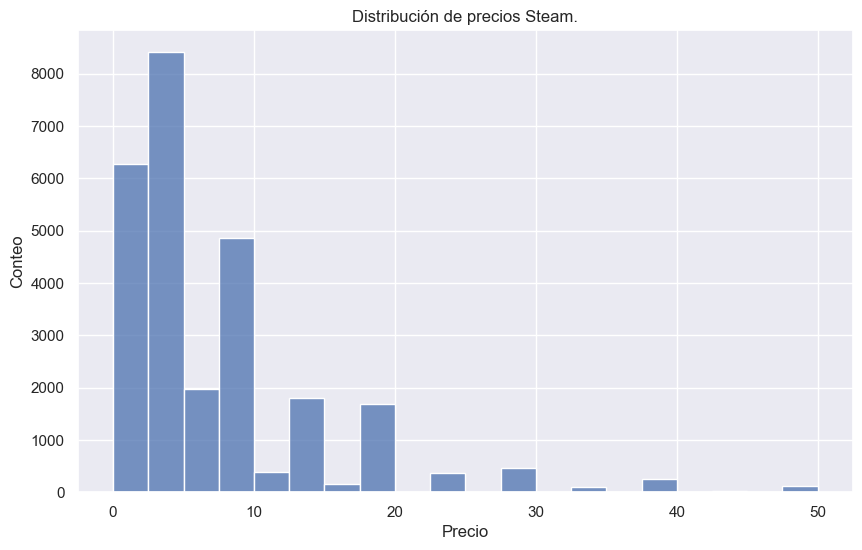

In [97]:
plt.figure(figsize=(10, 6))
sns.set(style='darkgrid')
ax = sns.histplot(pric_nout, bins=20)
ax.set(xlabel='Precio', ylabel='Conteo')
ax.set_title("Distribución de precios Steam.")
plt.show()

Podemos observar que dentro del rango de 0 a 10 dólares, se encuentran la gran mayoría de los artículos de steam, mientras que al pasar de 10 a 20, aún se encuentra una pequeña cantidad, no pasa lo mismo con los mayores a 20, que ya son muy pocos y no representan casi nada del set de datos, también podemos observar que la suma favorita para los juegos radica entre 2.5 y 5 dólares, observemos con la moda cuál es.

In [98]:
pric_nout.mode()

0   4.99
Name: price, dtype: float64

La moda es 5 dólares, pero, en formato 4.99 para la clásica estrategia de quitar el valor entero 5, y que nos fijemos en el 4, esta parece ser la suma preferida de los desarrolladores, esto debido a que la mayoría de estudios, aún pueden ganar una buena cantidad de dinero con esta suma, y una buena cantidad de atención en su juego, al no ser una suma alta.

## 5.2 Distribución estudios y publishers.

Ahora observemos qué estudios abarcan la mayor cantidad de juegos.

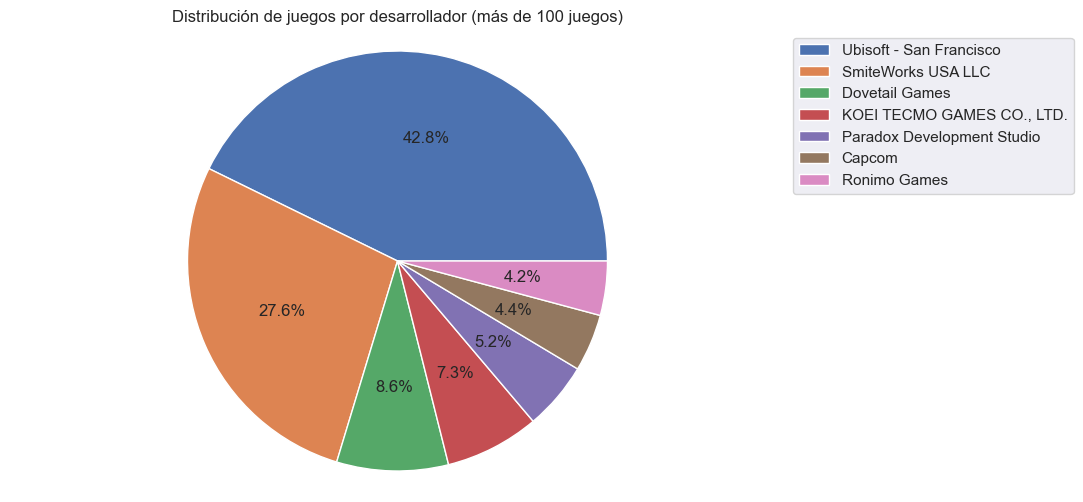

In [99]:
# Obtenemos los desarrolladores con más de 100 juegos lanzados para no saturar el gráfico.
dev_count = df_game['developer'].value_counts()
dev_count_f = dev_count[dev_count > 100]

# Creamos el gráfico.
plt.figure(figsize=(10, 6))
plt.pie(dev_count_f, autopct='%1.1f%%')
plt.title('Distribución de juegos por desarrollador (más de 100 juegos)')
plt.axis('equal')
# Mostramos los desarrolladores con su color.
plt.legend(dev_count_f.index, bbox_to_anchor=(1, 1))
plt.show()


Podemos ver que Ubisoft-San Francisco abarca el 42.8% de los juegos de los desarrolladores grandes, esto es casi la mitad lo que nos dice que el estudio genera mucho contenido, siendo el segundo puesto SmiteWorks USA LLC con 27.6 %, deja a todos los demás estudios juntos con menos de la cifra que abarca Ubisoft. Veamos si pasa lo mismo con los publisher.

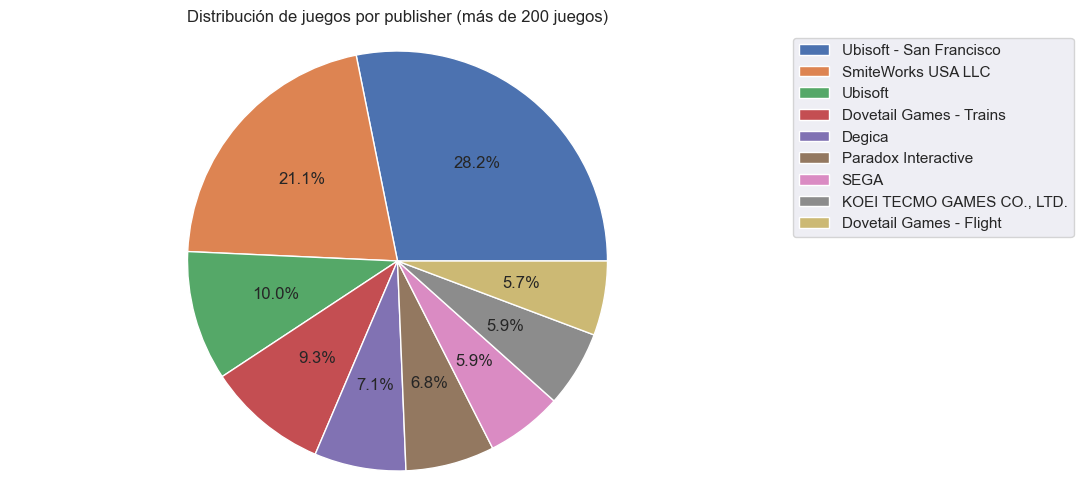

In [100]:
# Obtenemos los publisher con más de 200 juegos publicados para no saturar el gráfico.
pub_count = df_game['publisher'].value_counts()
pub_count_f = pub_count[pub_count > 200]

# Creamos el gráfico.
plt.figure(figsize=(10, 6))
plt.pie(pub_count_f, autopct='%1.1f%%')
plt.title('Distribución de juegos por publisher (más de 200 juegos)')
plt.axis('equal')
# Mostramos los publisher con su color.
plt.legend(pub_count_f.index, bbox_to_anchor=(1, 1))
plt.show()


Ubisoft y Smiteworks siguen teniendo una gran parte del gráfico, esta vez siendo aproximadamente un 5% total menos para Ubisoft. También podemos observar que la variedad y distribución de estudios cambió, siendo mayor la variabilidad en los developer.

## 5.3 Cantidad de juegos publicados por año

Observemos qué años se han publicado más o menos juegos, para obtener una aproximación del crecimiento en el interés de publicar los juegos en la plataforma Steam.

In [101]:
# Obtenemos la cantidad de registros por año, y vemos cuantos años son.
cant_per_year = df_game['year'].value_counts()
cant_per_year.index

Index([2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006,
       2005, 2003, 2018, 2004, 2001, 1998, 1999, 2002, 1997, 1996, 2000, 1994,
       1995, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1984, 1983, 1986, 2021,
       2019, 1985],
      dtype='int64', name='year')

Al ser tantos años, filtramos el dataframe para que los años desde el 2010, sean un dato.

In [102]:
# Guardamos la suma de la cantidad de los años antes del 2000.
antes_2010 = cant_per_year.loc[2010:].sum()
# Eliminamos los datos mencionados previamente.
cant_per_year.drop(cant_per_year.loc[2010:].index, inplace=True)
# Agregamos la sumatoria mencionada a el indice [1985-2010]
cant_per_year['1985 - 2010'] = antes_2010

Invertimos las series para que vayan del menor al mayor año, pues queremos ver el crecimiento.

In [103]:
cant_per_year = cant_per_year[::-1]

realizamos nuestro gráfico de distribución por año.

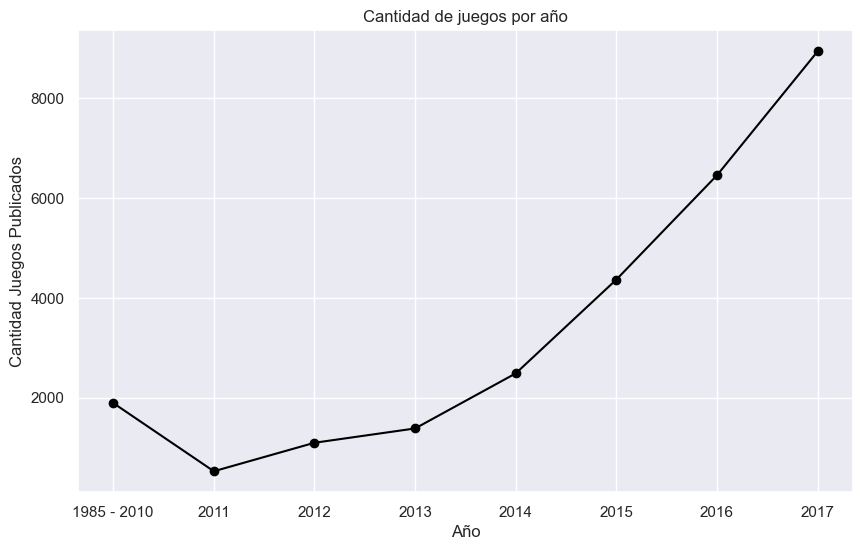

In [104]:
plt.figure(figsize=(10, 6))
# Convertimos los años a una lista de strings.
years = [str(year) for year in cant_per_year.index]
# Creamos el gráfico con los años y los valores en estos.
plt.plot(years, cant_per_year.values, marker='o', color='black')
plt.title("Cantidad de juegos por año")
plt.xlabel("Año")
plt.ylabel("Cantidad Juegos Publicados")
plt.show()

Podemos observar que entre 1985 y 2010, se hicieron 2mil juegos, esto fue muy poco para cada año, dado que son 25 años los que entran en ese rango. Suma la cual fue superada por completo en 2014, año en el cual se empieza a ver un gran crecimiento de la plataforma Steam, terminando en 2017 con más de 8mil juegos lanzados para ese año, cifra la cual probablemente no crezca mucho para la fecha, ya que actualmente, las compañías se centran más en tener un juego como servicio viable, que en lanzar muchos títulos, como es el caso de RockStar Games por ejemplo, creadores del famoso Grand Theft Auto, el cual entre 1999 y 2002, llegó a tener hasta 6 sagas nuevas, y luego, hasta 1 nueva por año. Hasta el 2013, en el cual su famoso juego como servicio Grand Theft Auto Online, basado en GTA V, ha sido su foco debido a la cantidad de dinero que reciben de este, y hasta 2024 llegándose a anunciar su sexto videojuego de esta saga: GTA VI. Esto son más de 10 años manteniendo un juego como servicio, y esto explica el por qué, al consultar una gráfica de el crecimiento de esta gráfica, probablemente no subirá exponencialmente, lo que sí lo hará, será la cantidad de títulos totales en Steam, no de lanzamientos por año.

## 5.4 Conclusión

Concluimos en que la plataforma Steam ha tenido un gran crecimiento en juegos publicados cada año desde el 2014, llegando a un límite difícil de superar en 2017, el cual se explica en su gráfica el por que. La gran mayoría de todos estos juegos, más del 50%, tienen un precio de 4.99 dólares o inferior, lo que nos indica que la mayoría son de estudios independientes también por su distribución de géneros, en la cual, Indie, predomina bastante, siendo 15mil títulos de 27mil con esta etiqueta. Sin embargo, la otra mitad, la abarcan estudios muy grandes, como lo pueden ser Ubisoft como vimos en la distribución de estudios y publishers. Y por último, entre las especificaciones que más dominan, tenemos a los juegos de Un jugador, y de multijugador con multiplataforma, esto debido a que el género de un solo jugador, siempre lo encontraremos cuando hablemos de videojuegos, ya que son experiencias únicas que cada jugador podrá vivir por su cuenta, mientras que, hablando del multijugador con multiplataforma, son juegos que conectan a aún más personas, ya que no están limitados por el dispositivo en el cual se usen, puedes conectar gente de un computador, con gente de consolas de videojuegos o celulares, haciendo que la experiencia grupal no tenga límites.

# 6. Análisis de datos (DataFrame Reseñas)
Analizamos las reseñas de los usuarios de Steam.

## 6.1 Cargamos los datos

In [105]:
df_rev = pd.read_csv('../Data/Processed/df_reviews.csv')

Previsualizamos

In [106]:
df_rev.head()

,id,item_id,recommend,sentiment,year
0,76561197970982479,1250,True,2,2011.00
1,76561197970982479,22200,True,2,2011.00
2,76561197970982479,43110,True,2,2011.00
3,js41637,251610,True,2,2014.00
4,js41637,227300,True,2,2013.00


Revisamos los valores nulos.

In [107]:
df_rev.isna().sum()

id              0
item_id         0
recommend       0
sentiment       0
year         6871
dtype: int64

Al ser la columna de año, no la usaremos en conjunto con las demás, así que los conservamos para no eliminar datos que nos pueden ser útiles de el resto de columnas.

## 6.2 Cantidad de reseñas por año

In [108]:
rev_per_y = df_rev['year'].value_counts()
rev_per_y

year
2014.00    13966
2015.00    12315
2013.00     4222
2012.00      772
2011.00      374
2010.00       51
Name: count, dtype: int64

Debemos sortear el dataframe antes para ver el progreso.

In [109]:
rev_per_y = rev_per_y.sort_index()

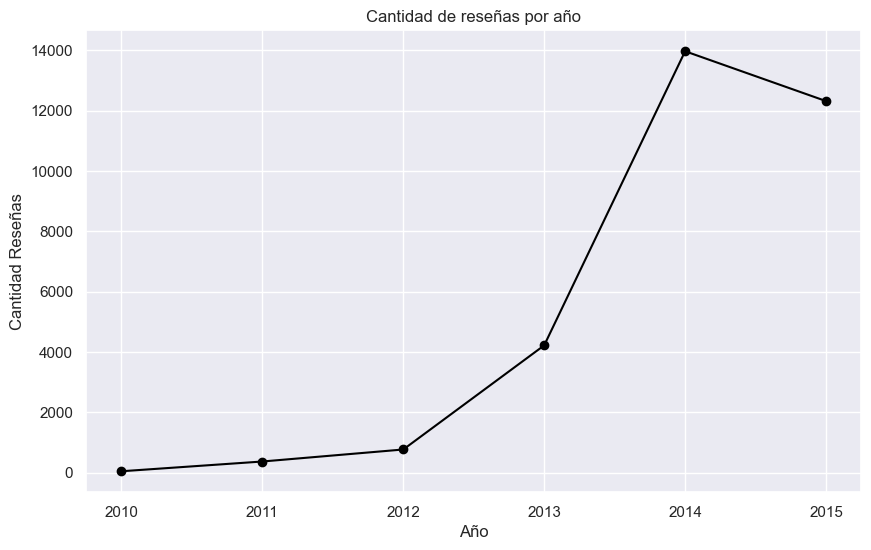

In [110]:
plt.figure(figsize=(10, 6))
revs = [int(rev) for rev in rev_per_y.index]
plt.plot(revs, rev_per_y.values, marker='o', color='black')
plt.title("Cantidad de reseñas por año")
plt.xlabel("Año")
plt.ylabel("Cantidad Reseñas")
plt.show()

Observando, nos damos cuenta que la popularidad de steam, el mismo año que mencionamos previamente en el EDA de juegos, fue el mismo que se disparó también en cuanto a interacción de los usuarios, el 2014, llegando a un pico de casi 14mil reseñas, una actividad bastante frecuente en la plataforma, también vemos que en el año 2010, que fue el que filtramos previamente junto a otros 25 años, los usuarios, a pesar de la cantidad de títulos publicados, no eran tan frecuentes en ese año, y su crecimiento fue tardando entre 3 y 4 años.

## 6.3 Distribución sentimiento y recomendaciones

Obtenemos la cantidad de cada categoría.

In [111]:
sentiments = df_rev['sentiment'].value_counts()
sentiments

sentiment
2    28177
0     6673
1     3721
Name: count, dtype: int64

In [112]:
recommends = df_rev['recommend'].value_counts()
recommends

recommend
True     33581
False     4990
Name: count, dtype: int64

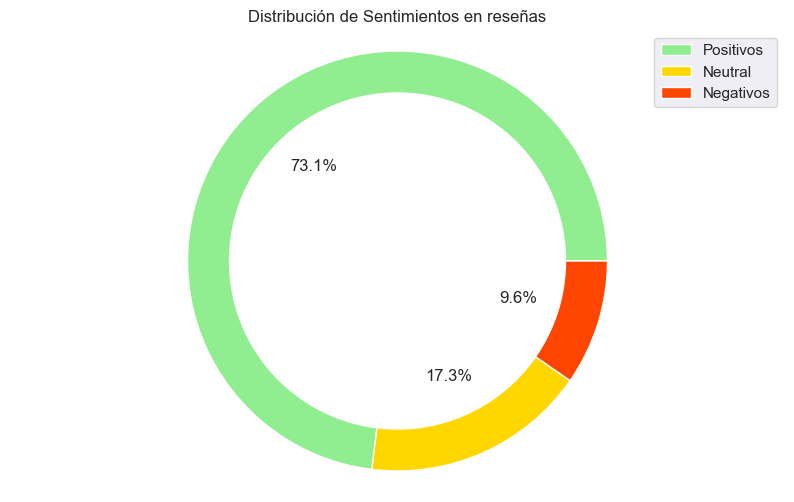

In [113]:
# Creamos el gráfico.
plt.figure(figsize=(10, 6))
plt.pie(sentiments.values, autopct='%1.1f%%', colors=['lightgreen', 'gold', 'orangered'])
plt.title('Distribución de Sentimientos en reseñas')
plt.axis('equal')
my_circle=plt.Circle( (0,0), 0.8, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
# Mostramos los publisher con su color.
plt.legend(['Positivos', 'Neutral', 'Negativos'], bbox_to_anchor=(1, 1))
plt.show()

Podemos observar que de 38,571 reseñas, una gran parte de ellas, 28,177 son positivas, y 3,721 negativas, esto debido a que, si tienes reseñas negativas, vas a tener muchos menos compradores en tu producto, por lo que los desarrolladores ante una ola de reseñas negativas, normalmente reaccionan modificando su producto para que sea más aceptado y pueda obtener una mejor calificación general.

---

Ahora miremos las recomendaciones.

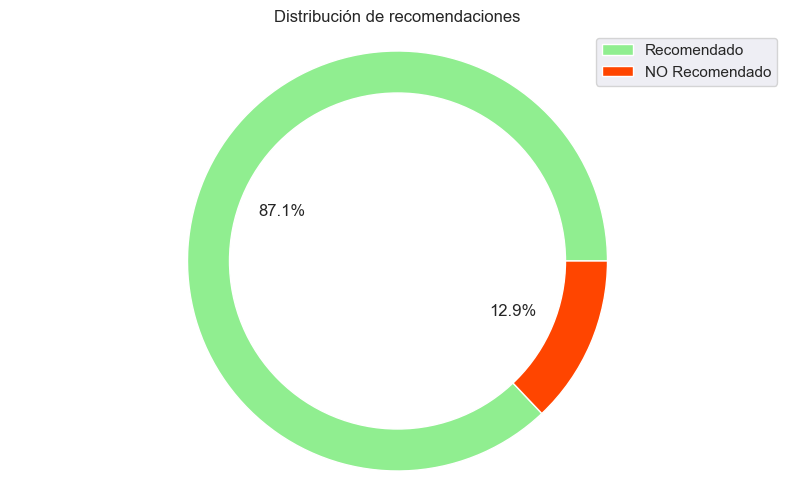

In [114]:
# Creamos el gráfico.
plt.figure(figsize=(10, 6))
plt.pie(recommends.values, autopct='%1.1f%%', colors=['lightgreen', 'orangered'])
plt.title('Distribución de recomendaciones')
plt.axis('equal')
my_circle=plt.Circle( (0,0), 0.8, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
# Mostramos los publisher con su color.
plt.legend(['Recomendado', 'NO Recomendado'], bbox_to_anchor=(1, 1))
plt.show()

El analizador de sentimiento que usamos para identificar lo que decían las reseñas, nos dio un dato muy acercado a lo que son respecto a su porcentaje de recomendación, siendo nuevamente, las positivas las que dominan mucho sobre las negativas. Para obtener muchas reseñas negativas, debes haber hecho un muy mal trabajo, ya que estas abarcan únicamente el 12.9% de todas las reseñas, esto es muy poco, y pasa muy pocas veces, ya que, si haces un mal trabajo, no ganarás nada en Steam, como fue el reciente caso en 2023 y 2024 del videojuego The Day Before, en el cual se anunciaron muchas cosas para él, y al momento de su llegada, al no tener casi ninguna de esas cosas anunciadas, y al ser un producto tan esperado y tan decepcionante, fue uno de los títulos peor valorados en la plataforma Steam, tanto que Steam habilitó a los usuarios para recibir un reembolso fuera de los términos que Steam normalmente tiene, es decir, todos los que querían, podían recuperar su dinero, y el estudio no se llevaría nada de eso, por lo que tener un juego mal valorado en Steam no sirve de nada, gracias a la protección al usuario de Steam, debido a esto los estudios hacen lo posible por reducir la cantidad de malas reseñas y recomendaciones, por lo que ese 12.9% de No recomendados, usualmente pertenecen a lo largo de todos los productos de steam, y no solo a unos cuantos, que normalmente terminan por acabar eliminados de la tienda cuando es el caso.

## 6.4 Idioma de las reseñas

Cargamos el dataframe de idiomas que preparamos anteriormente.

In [115]:
langs = pd.read_csv('../Data/Processed/langs_EDA.csv', index_col='Unnamed: 0')
langs

,Cantidad,Porcentaje
Inglés,38571,66.0 %
Otro,12514,21.4 %
Portugués,2119,3.62 %
Somalí,1840,3.14 %
Danés,1713,2.93 %
Español,1673,2.86 %


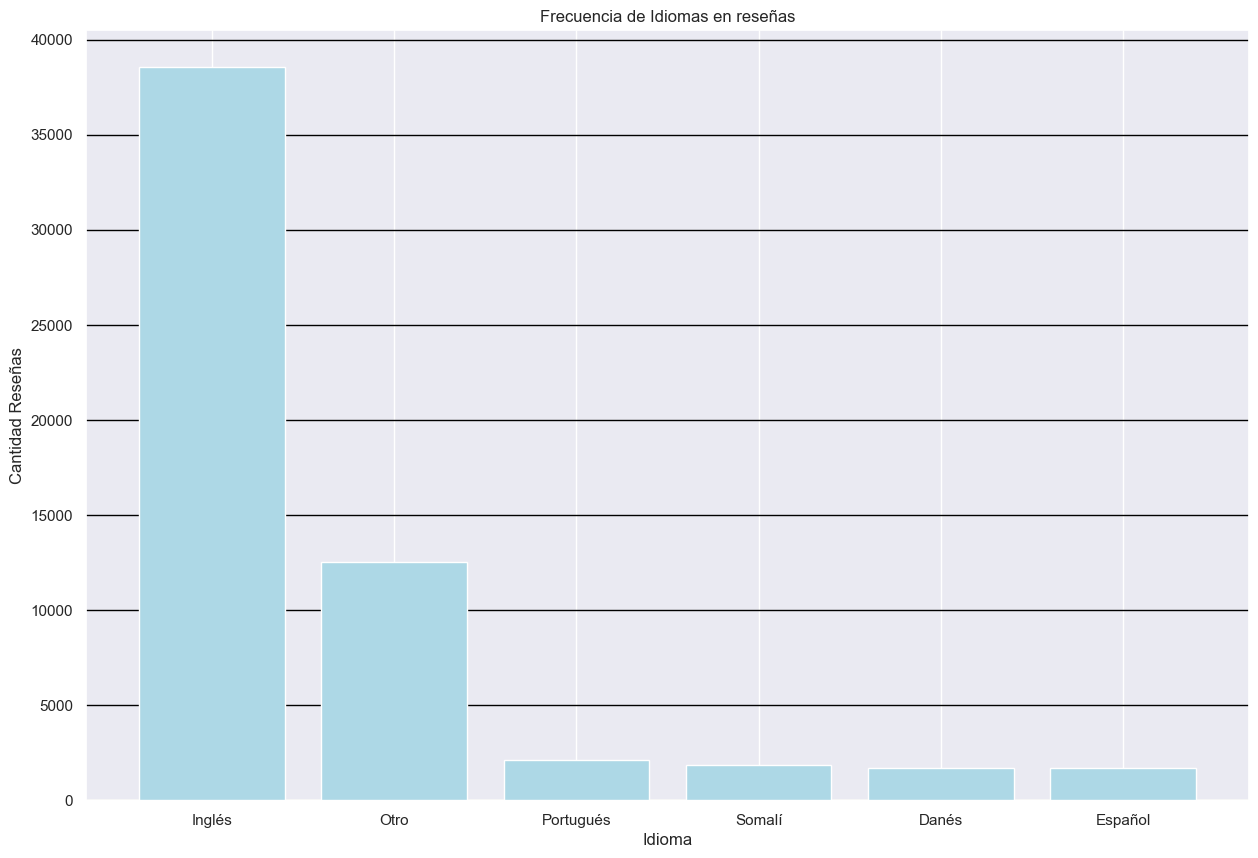

In [116]:
# Creamos la figura.
plt.figure(figsize=(15, 10))
# Grafico de barras con los indices de nuestro dataframe y los datos de Cantidad.
plt.bar(langs.index, langs['Cantidad'], color='lightblue', zorder=3)
plt.xlabel('Idioma')
plt.ylabel('Cantidad Reseñas')
plt.grid(axis='y', color='black', zorder=0)
plt.title('Frecuencia de Idiomas en reseñas')
plt.show()

Podemos observar que el inglés es el idioma más usado en las reseñas Australianas, siendo este uno de los principales idiomas del país, seguido de la columna otros, entre ellos se encuentran Dutch, Flemish, Welsh, Norwegian y Afrikaans. Todos estos teniendo aún menos cantidad de reseñas que los seguidos de otros, como el Portugués, Somalí, Danés y Español. Los cuales eran los más vistos después de inglés.

# 7. Análisis de Datos (DataFrame Objetos de Usuarios)

## 7.1 Cargamos los Datos

In [117]:
df_inv = pd.read_csv('../Data/Processed/items_api.csv')
df_inv.head()

,id,item_id,playtime_forever
0,76561197970982479,10,6
1,76561197970982479,20,0
2,76561197970982479,30,7
3,76561197970982479,40,0
4,76561197970982479,50,0


Verificamos los nulos.

In [118]:
df_inv.isna().sum()

id                  0
item_id             0
playtime_forever    0
dtype: int64

## 7.2 Tiempo de uso de los productos de los usuarios

### 7.2.1 Preparamos los datos

Describamos la columna para saber como podemos dividir los grupos.

In [119]:
pd.options.display.float_format = '{:.2f}'.format
df_inv['playtime_forever'].describe()

count   4244028.00
mean       1051.39
std        5671.26
min           0.00
25%           0.00
50%          47.00
75%         397.00
max      642773.00
Name: playtime_forever, dtype: float64

Podemos ver que hay un usuario con 600mil horas en un producto, lo que claramente es un error que tuvo como resultado ese outlier. También observamos que al menos el 25% de los objetos de los usuarios, no se han usado. Y que al menos la mitad de los juegos, se usan 47 horas. Por último la cifra aumenta demasiado en el tercer cuartil, en el que vemos que el 75% de los juegos se usan casi 400 horas, estos último, probablemente sean juegos competitivos, ya que son aquellos a los que se les puede dedicar una cantidad indefinida de tiempo, mientras que los juegos de un jugador, una vez se completan, usualmente se abandonan y la gran mayoría de estos pueden estar en el cuartil 2 (50%, 47 horas).

---

Categoricemos los juegos en base a su tiempo de uso.

In [120]:
intervalos = [-1, 1, 10, 100, 500, 1000, 3000, 10000, float('inf')]
etiquetas = ['Sin Uso (0 hrs)', 'Muy Bajo (1 - 10 hrs)', 'Bajo (11 - 100 hrs)', 'Medio (101 - 500 hrs)', 'Ato (501 - 1,000 hrs)', 'Muy alto (1,001 - 3,000 hrs)', 'Extremo (3,001 - 10,000 hrs)', 'Error 404 life not found (+10,001 hrs)']
# Utilizamos la función cut para categorizar la variable en los rangos que definimos.
cats = pd.cut(df_inv['playtime_forever'], bins=intervalos, labels=etiquetas, right=False)
# guardamos la información en una columna de nuestro df.
df_inv['cat'] = cats
# Contamos cuantas veces aparece cada una.
cats = cats.value_counts()
cats

playtime_forever
Sin Uso (0 hrs)                           1410392
Medio (101 - 500 hrs)                      852019
Bajo (11 - 100 hrs)                        767426
Muy alto (1,001 - 3,000 hrs)               352965
Ato (501 - 1,000 hrs)                      328032
Muy Bajo (1 - 10 hrs)                      269929
Extremo (3,001 - 10,000 hrs)               177603
Error 404 life not found (+10,001 hrs)      85662
Name: count, dtype: int64

Al ser valores muy grandes, los representaremos en porcentajes.

In [121]:
# Total de objetos.
total = cats.sum()
# Obtenemos el porcentaje.
cats = (cats/total)*100
cats

playtime_forever
Sin Uso (0 hrs)                          33.23
Medio (101 - 500 hrs)                    20.08
Bajo (11 - 100 hrs)                      18.08
Muy alto (1,001 - 3,000 hrs)              8.32
Ato (501 - 1,000 hrs)                     7.73
Muy Bajo (1 - 10 hrs)                     6.36
Extremo (3,001 - 10,000 hrs)              4.18
Error 404 life not found (+10,001 hrs)    2.02
Name: count, dtype: float64

### 7.2.2 Graficamos

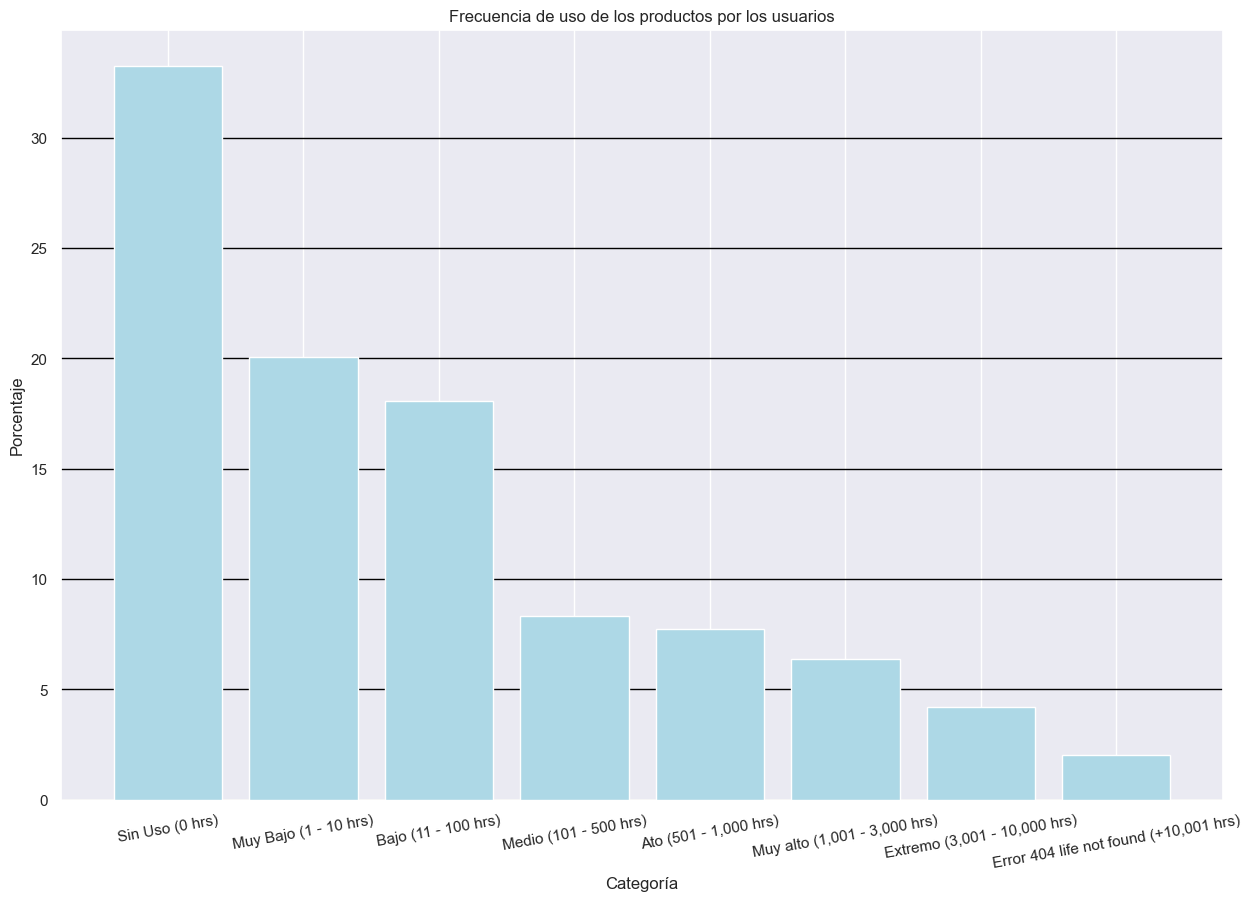

In [122]:
# Creamos el gráfico.
plt.figure(figsize=(15, 10))
# Creamos las barras con las etiquetas previamente creadas, y los valores en su porcentaje.
plt.bar(etiquetas, cats.values, color='lightblue', zorder=3)
plt.xlabel('Categoría')
plt.ylabel('Porcentaje')
plt.grid(axis='y', color='black', zorder=0)
plt.xticks(rotation=10)
plt.title('Frecuencia de uso de los productos por los usuarios')
plt.show()

Podemos ver que una gran cantidad de los objetos que tienen los usuarios, el 30%, no tienen ningún eso, la mayoría de estos, probablemente deben ser productos gratis, o que estuvieron gratis durante un tiempo, y los usuarios reclaman este contenido o lo agregan a su biblioteca y nunca lo usan o lo planean usar después, analizaremos también los productos que valgan dinero para ver si esta cantidad de productos sin usar disminuye. En las siguientes categorías, de 1 a 10 horas y de 11 a 100 horas, están el 20% y 18% respectivamente, una cifra también alta para el total de objetos, y que en dicha categoría, pueden estar desde juegos sin terminar, o juegos muy cortos, los cuales se terminan rápidamente, recientemente hubo una polémica en Steam, en la que la gente que terminaba juegos rápidos, solicitaba un reembolso de estos, haciendo a los estudios pequeños perder dinero, y aún así, habiendo usado sus productos, una practica que perjudica mucho a los desarrolladores pequeños. Luego las demás categorías, como mencioné, pueden ser juegos competitivos o juegos triple A con demasiado contenido, tales como Counter-strike o Red Dead Redemption 2, respectivamente, en el que uno, es un juego competitivo de disparos, en el que el tiempo de juego es indefinido y depende de que tanto quieras subir entre los mejores jugadores, y para mantenerte allí, aún debes seguir jugando, y el otro, es un juego triple A con una extensa cantidad de cosas por hacer, al ser uno de los videojuegos de mundo abierto con más atención a los detalles y más contenido para disfrutar, en el cual, puede ser rápido completar su historia principal, pero al ser un mundo abierto, siempre hay algo por hacer o explorar, en estos casos, el tiempo de juego puede oscilar entre alto, muy alto y extremo, y esta categoría es significativamente menor a las demás, ya que no todos tienen ese tiempo para invertir en un videojuego en específico.

## 7.2 Tiempo de uso de los productos de pago vs productos gratis

### 7.2.1 Preparamos los datos

In [276]:
df_with_prices = pd.merge(df_inv, df_game, left_on='item_id', right_on='id', how='inner').drop(columns=['id_y'])

In [277]:
# Identificamos los productos gratuitos.
mask = df_with_prices['price'] == 0
# Filtramos los gratuitos en su categoría de uso previamente creada.
df_free = df_with_prices[mask]['cat']
# Filtramos los de pago, negando la anterior máscara en su categoría previamente creada.
df_pay = df_with_prices[~mask]['cat']

Verificamos que las muestras sean del mismo tamaño.

In [278]:
print(df_free.shape)
df_pay.shape

(736172,)


(3283843,)

Al no serlo, tomamos una muestra del conjunto mayor, en este caso, el de pago.

In [279]:
df_pay = df_pay.sample(n=df_free.shape[0])

Verificamos y guardamos el total para usarlo como base del porcentaje de aparición.

In [280]:
total = df_pay.shape[0]
total

736172

Ahora podemos contar las categorías en cada uno.

In [281]:
df_pay = df_pay.value_counts()
df_free = df_free.value_counts()

dividimos las categorías sobre el total previamente extraido.

In [284]:
df_pay = (df_pay/total)*100
df_free = (df_free/total)*100

Verificamos cada serie resultante.

In [285]:
df_pay = df_pay.reset_index()
df_pay

,cat,count
0,Sin Uso (0 hrs),33.60
1,Medio (101 - 500 hrs),20.97
2,Bajo (11 - 100 hrs),16.67
3,"Muy alto (1,001 - 3,000 hrs)",8.74
4,"Ato (501 - 1,000 hrs)",8.19
5,Muy Bajo (1 - 10 hrs),5.23
6,"Extremo (3,001 - 10,000 hrs)",4.43
7,"Error 404 life not found (+10,001 hrs)",2.17


In [286]:
df_free = df_free.reset_index()
df_free

,cat,count
0,Sin Uso (0 hrs),29.86
1,Bajo (11 - 100 hrs),24.03
2,Medio (101 - 500 hrs),17.77
3,Muy Bajo (1 - 10 hrs),10.53
4,"Muy alto (1,001 - 3,000 hrs)",6.74
5,"Ato (501 - 1,000 hrs)",6.39
6,"Extremo (3,001 - 10,000 hrs)",3.24
7,"Error 404 life not found (+10,001 hrs)",1.45


Creamos el gráfico.

Combinamos los datos para simplificar la creación del gráfico en seaborn.

In [287]:
df_pay['type'] = 'De pago'
df_free['type'] = 'Gratis'
datos = pd.concat([df_pay, df_free])
datos

,cat,count,type
0,Sin Uso (0 hrs),33.60,De pago
1,Medio (101 - 500 hrs),20.97,De pago
2,Bajo (11 - 100 hrs),16.67,De pago
3,"Muy alto (1,001 - 3,000 hrs)",8.74,De pago
4,"Ato (501 - 1,000 hrs)",8.19,De pago
5,Muy Bajo (1 - 10 hrs),5.23,De pago
6,"Extremo (3,001 - 10,000 hrs)",4.43,De pago
7,"Error 404 life not found (+10,001 hrs)",2.17,De pago
0,Sin Uso (0 hrs),29.86,Gratis
1,Bajo (11 - 100 hrs),24.03,Gratis


### 7.2.2 Graficamos

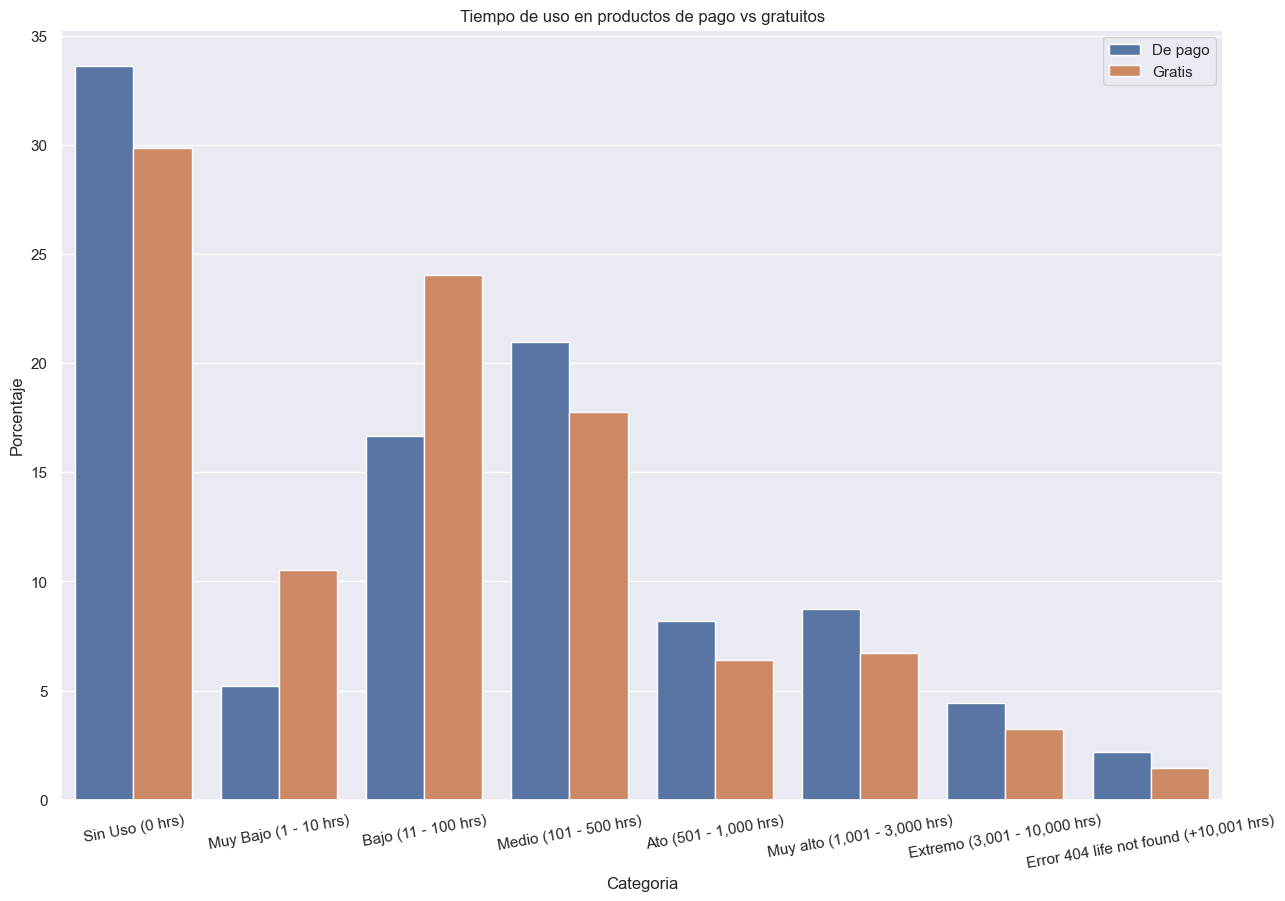

In [290]:
plt.figure(figsize=(15, 10))
sns.set(style="darkgrid")
sns.barplot(x='cat', y='count', hue='type', data=datos)
plt.xticks(rotation=10)
plt.xlabel('Categoria')
plt.ylabel('Porcentaje')
plt.legend()
plt.title("Tiempo de uso en productos de pago vs gratuitos")
plt.show()

Podemos observar que a pesar de tener una muestra igual en productos tanto de pago como gratis, el porcentaje de estos que no se usan, sigue siendo mayor para los de pago, algo extraño debido a que si alguien paga por un producto, lo debería usar más que alguien que no lo hace, sin embargo luego esto se puede notar en que las cantidades altas de tiempos de uso las dominan los productos de pago, aunque no por mucho, mientras que las cantidades bajas de tiempo, los productos gratis, esto puede ser debido a que en Steam hay demos de juegos de pago, que son gratis y pueden completarse en este rango de precio.

# Final
Muchas gracias por quedarte hasta acá en en análisis de datos exploratorio, con este análisis entendimos mejor los datos, como funciona la plataforma Steam en ciertas áreas y pudimos ver estadísticas de distribución y crecimiento en áreas interesantes de los datos.